# Proyecto final de Master Big Data & Business Analitycs

El Trabajo de Fin de Máster "Digital Eye: A Predictive Approach to Glaucoma Detection" se centra en el desarrollo de modelos predictivos para la detección temprana del glaucoma. La implementación de una aplicación práctica permite evaluar estos modelos de manera accesible y útil para los usuarios. Se destaca la importancia de la tecnología desarrollada en la detección y manejo efectivo del glaucoma, con el objetivo de mejorar la calidad de vida de los pacientes y la sostenibilidad de los sistemas de atención médica.


In [ ]:
# Función para instalar las dependencias necesarias
def install_dependencies():
    !pip install torch torchvision torchsummary scikit-learn seaborn tqdm
    !pip install efficientnet_pytorch

install_dependencies()

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=59d87c82d04e7e01b71f492bfdc24557e811110fd41205a3ac80416f1cd55d69
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Mounted at /content/drive
                                           enlace           etiqueta  id_clase
0    /content/input/train/0/REFUGE1-train-190.png  Presenta Glaucoma         0
1  /content/input/train/0/OIA-ODIR-TRAIN-1930.png  Presenta Glaucoma         0
2            /content/input/train/0/PAPILA-68.png  Presenta Glaucoma         0
3      /content/input/train/0/REFUGE1-val-244.png  Presenta Glaucoma         0
4            /content/input/train/0/ORIGA-502.png  Presenta Glaucoma         0


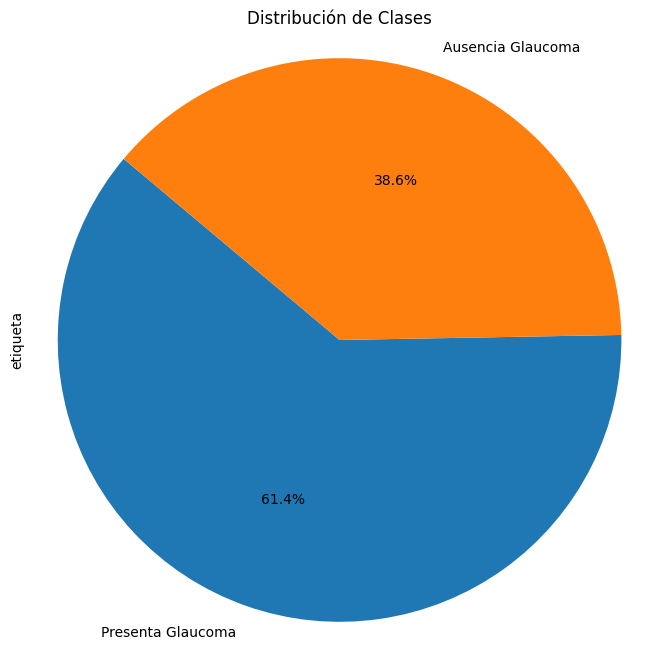

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision.transforms import v2
from PIL import Image
from efficientnet_pytorch import EfficientNet
from google.colab import files
from google.colab import drive
from shutil import copytree


# Función para cargar los datos de las imágenes
def load_data(data_path, label_map):
    df = pd.DataFrame(columns=["enlace", "etiqueta", "id_clase"])
    for folder, label in label_map.items():
        img_path = os.path.join(data_path, folder)
        jpg_list = glob(os.path.join(img_path, '*.png'))
        data = pd.DataFrame({"enlace": jpg_list, "etiqueta": label, "id_clase": int(folder)})
        df = pd.concat([df, data], ignore_index=True)
    return df

# Función para descargar y descomprimir el conjunto de datos de Kaggle
def download_dataset():
    # Montar Google Drive
    drive.mount('/content/drive')
    # Ruta de la carpeta en tu Google Drive
    dataset_folder_path = '/content/drive/My Drive/data'
    # Directorio de destino para el conjunto de datos en Colab
    colab_dataset_path = '/content/input/'
    # Copiar la carpeta del conjunto de datos a Colab
    copytree(dataset_folder_path, colab_dataset_path)

# Función para cargar los conjuntos de entrenamiento, validación y prueba
def load_datasets(train_path, val_path, test_path, label_map):
    train_df = load_data(train_path, label_map)
    val_df = load_data(val_path, label_map)
    test_df = load_data(test_path, label_map)
    return train_df, val_df, test_df

# Función para convertir los tipos de datos necesarios en los DataFrames
def convert_data_types(train_df, val_df, test_df):
    train_df[["enlace", "etiqueta"]] = train_df[["enlace", "etiqueta"]].astype(str)
    train_df[["id_clase"]] = train_df[["id_clase"]].astype(int)
    val_df[["enlace", "etiqueta"]] = val_df[["enlace", "etiqueta"]].astype(str)
    val_df[["id_clase"]] = val_df[["id_clase"]].astype(int)
    test_df[["enlace", "etiqueta"]] = test_df[["enlace", "etiqueta"]].astype(str)
    test_df[["id_clase"]] = test_df[["id_clase"]].astype(int)
    return train_df, val_df, test_df

# Función para mostrar las primeras filas de un dataframe
def show_head(df):
    print(df.head())

# Función para visualizar la distribución de clases en un gráfico circular
def visualize_class_distribution(df):
    plt.figure(figsize=(8, 8))
    df["etiqueta"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Hace que el gráfico sea un círculo en lugar de una elipse
    plt.title('Distribución de Clases')
    plt.show()

# Definir las rutas y el mapeo de etiquetas
train_path = '/content/input/train'
val_path = '/content/input/val'
test_path = '/content/input/test'
label_map = {
    "0": "Presenta Glaucoma",
    "1": "Ausencia Glaucoma",
}

# Ejecutar las funciones en el orden adecuado
install_dependencies()
download_dataset()
train_df, val_df, test_df = load_datasets(train_path, val_path, test_path, label_map)
train_df, val_df, test_df = convert_data_types(train_df, val_df, test_df)
show_head(train_df)
visualize_class_distribution(train_df)


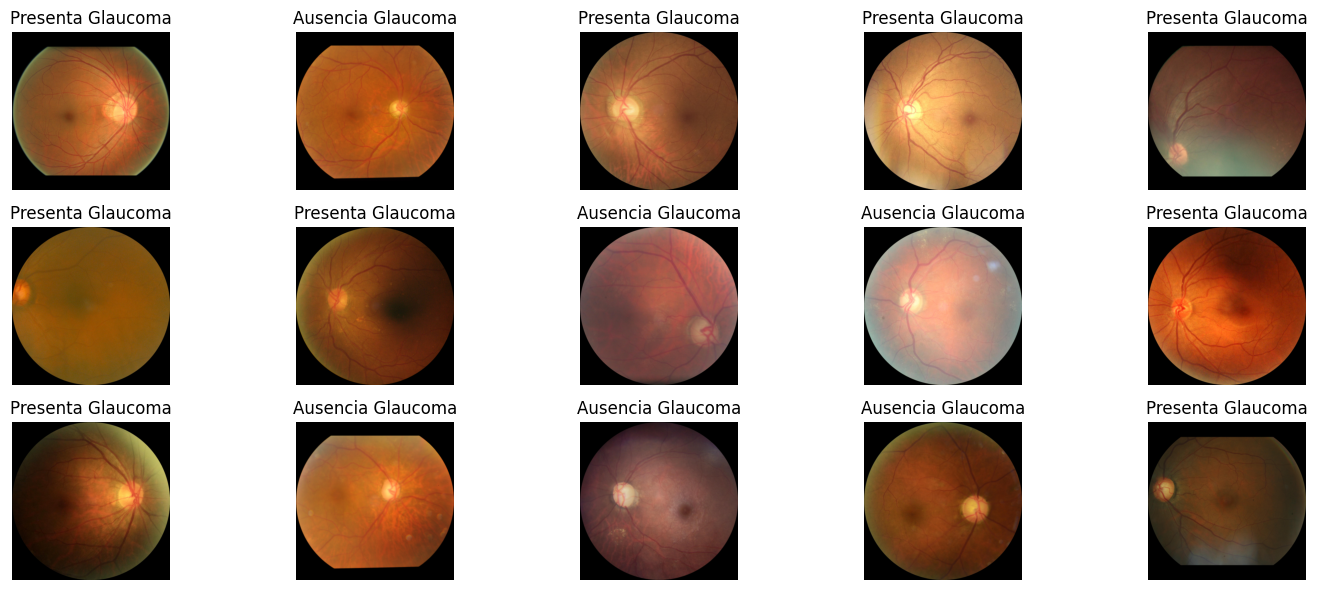

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar imágenes de manera aleatoria
def show_random_images(data_df, num_images=15, rows=3, cols=5, figsize=(15, 6)):
    random_idxs = np.random.choice(len(data_df), size=num_images, replace=False)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i, idx in enumerate(random_idxs):
        row = i // cols
        col = i % cols
        enlace = data_df.loc[idx, 'enlace']
        img = plt.imread(enlace)
        axes[row, col].imshow(img)
        axes[row, col].set_title(data_df.loc[idx, 'etiqueta'])
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Uso de la función para mostrar imágenes de entrenamiento de manera aleatoria
show_random_images(train_df)


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from PIL import Image

def define_transforms(is_train=True):
    if is_train:
        transforms = v2.Compose([
            v2.Resize(256),
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
            v2.RandomErasing(p=0.5, scale=(0.1, 0.15)),
            v2.PILToTensor(),
            v2.ToDtype(torch.float32,  scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transforms = v2.Compose([
            v2.Resize((224, 224)),
            v2.PILToTensor(),
            v2.ToDtype(torch.float32,  scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    return transforms

def create_dataset_and_loader(dataframe, transforms, batch_size, num_workers, is_train=True):
    dataset = MyDataset(dataframe, transforms)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)
    return dataset, loader

# Define la clase del conjunto de datos
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['enlace']
        img = Image.open(image_path).convert("RGB")
        transformed_img = self.transforms_(img)
        id_clase = self.df.iloc[index]['id_clase']
        return transformed_img, id_clase

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 2 if device == 'cuda' else 4

BATCH_SIZE=32

# Definir las transformaciones para entrenamiento y prueba
train_transforms = define_transforms(is_train=True)
test_transforms = define_transforms(is_train=False)

# Crear conjuntos de datos y cargadores de datos
train_dataset, train_loader = create_dataset_and_loader(train_df, train_transforms, BATCH_SIZE, num_workers, is_train=True)
val_dataset, val_loader = create_dataset_and_loader(val_df, test_transforms, BATCH_SIZE, num_workers, is_train=False)
test_dataset, test_loader = create_dataset_and_loader(test_df, test_transforms, BATCH_SIZE, num_workers, is_train=False)

# Imprimir la cantidad de datos en los conjuntos de entrenamiento y validación
print(f'training data:{len(train_df)}')
print(f'validation data:{len(val_df)}')


training data:8621
validation data:5747


In [10]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import os
from tqdm import tqdm
import numpy as np

class NeuralNetworkManager:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, lr_scheduler, device, checkpoint_dir="checkpoints"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.checkpoint_dir = checkpoint_dir
        self.patience = 10
        self.counter = 0
        self.best_loss = np.inf
        self.logs = {'training_loss': [], 'training_accuracy': [], 'validation_loss': [], 'validation_accuracy': []}


        if not os.path.exists(self.checkpoint_dir):
            os.mkdir(self.checkpoint_dir)

    def train(self, epochs):
        for epoch in tqdm(range(epochs)):
            training_accuracy, training_loss = self._train_epoch()
            validation_accuracy, validation_loss = self._validate()
            print(f'EPOCH: {epoch} \
                training_loss: {training_loss:.4f}, training_accuracy: {training_accuracy:.3f} \
                validation_loss: {validation_loss:.4f}, validation_accuracy: {validation_accuracy:.3f} \
                Learning Rate: {self.optimizer.param_groups[0]["lr"]}')

            self.logs['training_loss'].append(training_loss)
            self.logs['training_accuracy'].append(training_accuracy)
            self.logs['validation_loss'].append(validation_loss)
            self.logs['validation_accuracy'].append(validation_accuracy)

            torch.save(self.model.state_dict(), os.path.join(self.checkpoint_dir, "last.pth"))

            # Verificar mejora
            if validation_loss < self.best_loss:
                self.counter = 0
                self.best_loss = validation_loss
                torch.save(self.model.state_dict(), os.path.join(self.checkpoint_dir, "best.pth"))
            else:
                self.counter += 1

            # Detener temprano si no hay mejora
            if self.counter >= self.patience:
                print("Earlystop!")
                break

            self.lr_scheduler.step()

    def _train_epoch(self):
        size = len(self.train_loader.dataset)
        num_batches = len(self.train_loader)
        self.model.train()
        epoch_loss = 0.0
        epoch_correct = 0

        for (data_, target_) in self.train_loader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(self.device), target_.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(data_)
            loss = self.criterion(outputs, target_)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            epoch_correct += torch.sum(pred == target_).item()

        return epoch_correct / size, epoch_loss / num_batches

    def _validate(self):
        size = len(self.val_loader.dataset)
        num_batches = len(self.val_loader)
        epoch_loss = 0.0
        epoch_correct = 0

        with torch.no_grad():
            self.model.eval()
            for (data_, target_) in self.val_loader:
                target_ = target_.type(torch.LongTensor)
                data_, target_ = data_.to(self.device), target_.to(self.device)

                outputs = self.model(data_)
                loss = self.criterion(outputs, target_)

                epoch_loss += loss.item()
                _, pred = torch.max(outputs, dim=1)
                epoch_correct += torch.sum(pred == target_).item()

        return epoch_correct / size, epoch_loss / num_batches

    def plot_loss_and_accuracy(self):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.logs['training_loss'], label='Pérdida en Entrenamiento')
        plt.plot(self.logs['validation_loss'], label='Pérdida en Validación')
        plt.title('Pérdida en Entrenamiento y Validación', fontsize=20)
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(self.logs['training_accuracy'], label='Precisión en Entrenamiento')
        plt.plot(self.logs['validation_accuracy'], label='Precisión en Validación')
        plt.title('Exactitud en Entrenamiento y Validación', fontsize=20)
        plt.legend()
        plt.show()

    def evaluate_model_on_test_set(self, test_loader):
        model.load_state_dict(torch.load(os.path.join(self.checkpoint_dir, 'best.pth')))
        model.eval()

        y_true, y_pred = [], []

        with torch.no_grad():
            for (data_, target_) in tqdm(test_loader):
                target_ = target_.type(torch.LongTensor)
                data_, target_ = data_.to(self.device), target_.to(self.device)
                outputs = model(data_)
                _, pred = torch.max(outputs, dim=1)
                y_true.extend(target_.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())

        y_pred = np.array(y_pred)
        y_true = np.array(y_true)

        return y_true, y_pred

    def plot_confusion_matrix_and_report(self, y_true, y_pred, label_list):
        ax = plt.subplot()
        CM = confusion_matrix(y_true, y_pred)
        sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu_r',
                    xticklabels=label_list, yticklabels=label_list)
        ax.set_xlabel('Etiquetas predichas')
        ax.set_ylabel('Etiquetas verdaderas')
        ax.set_title('Matriz de Confusion')
        plt.show()

        clf_report = classification_report(y_true, y_pred, target_names=label_list)
        print(clf_report)

    def visualize_predictions(self, num_images_to_display, test_dataset, label_list):
        self.model.load_state_dict(torch.load(os.path.join(self.checkpoint_dir, 'best.pth')))
        self.model.eval()

        sample_indices = np.random.choice(len(test_dataset), num_images_to_display, replace=False)

        num_cols = 2
        num_rows = int(np.ceil(num_images_to_display / num_cols))
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))

        for i, idx in enumerate(sample_indices):
            img, true_label = test_dataset[idx]
            img = img.unsqueeze(0).to(self.device)

            with torch.no_grad():
                output = self.model(img)
                _, predicted_label = torch.max(output, 1)

            img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            row_idx, col_idx = divmod(i, num_cols)
            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].axis('off')
            axs[row_idx, col_idx].set_title(f'Real: {label_list[true_label]}\nPredicción: {label_list[predicted_label.item()]}', fontsize=8)

        for ax in axs.flatten()[num_images_to_display:]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Número de épocas
EPOCHS = 100

# Crear el modelo
class_size = 2
model = models.efficientnet_v2_s(weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(1280, class_size)
model.to(device)

# Criterio de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
learning_rate = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Planificador de tasa de aprendizaje
lr_milestones = [8, 16, 24, 30, 36]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Crear el objeto NeuralNetworkManager
trainer = NeuralNetworkManager(model, train_loader, val_loader, criterion, optimizer, multi_step_lr_scheduler, device)

# Entrenamiento
trainer.train(EPOCHS)


  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 0                 training_loss: 0.4978, training_accuracy: 0.763                 validation_loss: 0.3426, validation_accuracy: 0.851                 Learning Rate: 0.0001


  1%|          | 1/100 [01:57<3:14:38, 117.96s/it]

EPOCH: 1                 training_loss: 0.4066, training_accuracy: 0.817                 validation_loss: 0.2826, validation_accuracy: 0.876                 Learning Rate: 0.0001


  2%|▏         | 2/100 [03:55<3:12:31, 117.87s/it]

EPOCH: 2                 training_loss: 0.3678, training_accuracy: 0.836                 validation_loss: 0.2674, validation_accuracy: 0.886                 Learning Rate: 0.0001


  3%|▎         | 3/100 [05:53<3:10:31, 117.85s/it]

EPOCH: 3                 training_loss: 0.3479, training_accuracy: 0.844                 validation_loss: 0.2471, validation_accuracy: 0.895                 Learning Rate: 0.0001


  4%|▍         | 4/100 [07:51<3:08:19, 117.70s/it]

EPOCH: 4                 training_loss: 0.3374, training_accuracy: 0.853                 validation_loss: 0.2499, validation_accuracy: 0.893                 Learning Rate: 0.0001


  5%|▌         | 5/100 [09:48<3:06:18, 117.66s/it]

EPOCH: 5                 training_loss: 0.3227, training_accuracy: 0.862                 validation_loss: 0.2154, validation_accuracy: 0.914                 Learning Rate: 0.0001


  6%|▌         | 6/100 [11:46<3:04:27, 117.74s/it]

EPOCH: 6                 training_loss: 0.3173, training_accuracy: 0.863                 validation_loss: 0.2413, validation_accuracy: 0.898                 Learning Rate: 0.0001


  7%|▋         | 7/100 [13:44<3:02:22, 117.66s/it]

EPOCH: 7                 training_loss: 0.3067, training_accuracy: 0.867                 validation_loss: 0.2054, validation_accuracy: 0.916                 Learning Rate: 0.0001


  8%|▊         | 8/100 [15:41<3:00:23, 117.65s/it]

EPOCH: 8                 training_loss: 0.2784, training_accuracy: 0.878                 validation_loss: 0.1793, validation_accuracy: 0.924                 Learning Rate: 1e-05


  9%|▉         | 9/100 [17:39<2:58:41, 117.82s/it]

EPOCH: 9                 training_loss: 0.2627, training_accuracy: 0.890                 validation_loss: 0.1727, validation_accuracy: 0.926                 Learning Rate: 1e-05


 10%|█         | 10/100 [19:37<2:56:50, 117.89s/it]

EPOCH: 10                 training_loss: 0.2671, training_accuracy: 0.886                 validation_loss: 0.1664, validation_accuracy: 0.928                 Learning Rate: 1e-05


 11%|█         | 11/100 [21:35<2:54:51, 117.88s/it]

EPOCH: 11                 training_loss: 0.2526, training_accuracy: 0.890                 validation_loss: 0.1597, validation_accuracy: 0.930                 Learning Rate: 1e-05


 12%|█▏        | 12/100 [23:33<2:52:48, 117.82s/it]

EPOCH: 12                 training_loss: 0.2571, training_accuracy: 0.887                 validation_loss: 0.1535, validation_accuracy: 0.933                 Learning Rate: 1e-05


 13%|█▎        | 13/100 [25:31<2:50:52, 117.85s/it]

EPOCH: 13                 training_loss: 0.2510, training_accuracy: 0.889                 validation_loss: 0.1535, validation_accuracy: 0.935                 Learning Rate: 1e-05


 14%|█▍        | 14/100 [27:29<2:49:07, 117.99s/it]

EPOCH: 14                 training_loss: 0.2493, training_accuracy: 0.894                 validation_loss: 0.1467, validation_accuracy: 0.937                 Learning Rate: 1e-05


 15%|█▌        | 15/100 [29:27<2:47:02, 117.91s/it]

EPOCH: 15                 training_loss: 0.2416, training_accuracy: 0.895                 validation_loss: 0.1464, validation_accuracy: 0.938                 Learning Rate: 1e-05


 16%|█▌        | 16/100 [31:24<2:44:53, 117.78s/it]

EPOCH: 16                 training_loss: 0.2307, training_accuracy: 0.898                 validation_loss: 0.1475, validation_accuracy: 0.937                 Learning Rate: 1.0000000000000002e-06


 17%|█▋        | 17/100 [33:22<2:43:02, 117.86s/it]

EPOCH: 17                 training_loss: 0.2279, training_accuracy: 0.900                 validation_loss: 0.1479, validation_accuracy: 0.938                 Learning Rate: 1.0000000000000002e-06


 18%|█▊        | 18/100 [35:20<2:41:01, 117.82s/it]

EPOCH: 18                 training_loss: 0.2438, training_accuracy: 0.895                 validation_loss: 0.1464, validation_accuracy: 0.938                 Learning Rate: 1.0000000000000002e-06


 19%|█▉        | 19/100 [37:18<2:39:02, 117.80s/it]

EPOCH: 19                 training_loss: 0.2292, training_accuracy: 0.903                 validation_loss: 0.1406, validation_accuracy: 0.940                 Learning Rate: 1.0000000000000002e-06


 20%|██        | 20/100 [39:15<2:36:55, 117.70s/it]

EPOCH: 20                 training_loss: 0.2314, training_accuracy: 0.900                 validation_loss: 0.1414, validation_accuracy: 0.940                 Learning Rate: 1.0000000000000002e-06


 21%|██        | 21/100 [41:13<2:35:06, 117.81s/it]

EPOCH: 21                 training_loss: 0.2347, training_accuracy: 0.899                 validation_loss: 0.1395, validation_accuracy: 0.940                 Learning Rate: 1.0000000000000002e-06


 22%|██▏       | 22/100 [43:11<2:33:11, 117.84s/it]

EPOCH: 22                 training_loss: 0.2358, training_accuracy: 0.898                 validation_loss: 0.1429, validation_accuracy: 0.940                 Learning Rate: 1.0000000000000002e-06


 23%|██▎       | 23/100 [45:09<2:31:03, 117.71s/it]

EPOCH: 23                 training_loss: 0.2361, training_accuracy: 0.896                 validation_loss: 0.1416, validation_accuracy: 0.939                 Learning Rate: 1.0000000000000002e-06


 24%|██▍       | 24/100 [47:07<2:29:06, 117.72s/it]

EPOCH: 24                 training_loss: 0.2334, training_accuracy: 0.899                 validation_loss: 0.1379, validation_accuracy: 0.942                 Learning Rate: 1.0000000000000002e-07


 25%|██▌       | 25/100 [49:05<2:27:33, 118.05s/it]

EPOCH: 25                 training_loss: 0.2279, training_accuracy: 0.902                 validation_loss: 0.1396, validation_accuracy: 0.942                 Learning Rate: 1.0000000000000002e-07


 26%|██▌       | 26/100 [51:03<2:25:18, 117.81s/it]

EPOCH: 26                 training_loss: 0.2336, training_accuracy: 0.901                 validation_loss: 0.1384, validation_accuracy: 0.942                 Learning Rate: 1.0000000000000002e-07


 27%|██▋       | 27/100 [53:00<2:23:13, 117.71s/it]

EPOCH: 27                 training_loss: 0.2308, training_accuracy: 0.900                 validation_loss: 0.1425, validation_accuracy: 0.940                 Learning Rate: 1.0000000000000002e-07


 28%|██▊       | 28/100 [54:58<2:21:10, 117.64s/it]

EPOCH: 28                 training_loss: 0.2296, training_accuracy: 0.900                 validation_loss: 0.1386, validation_accuracy: 0.941                 Learning Rate: 1.0000000000000002e-07


 29%|██▉       | 29/100 [56:56<2:19:25, 117.82s/it]

EPOCH: 29                 training_loss: 0.2351, training_accuracy: 0.898                 validation_loss: 0.1382, validation_accuracy: 0.942                 Learning Rate: 1.0000000000000002e-07


 30%|███       | 30/100 [58:54<2:17:25, 117.80s/it]

EPOCH: 30                 training_loss: 0.2324, training_accuracy: 0.899                 validation_loss: 0.1381, validation_accuracy: 0.943                 Learning Rate: 1.0000000000000004e-08


 31%|███       | 31/100 [1:00:51<2:15:24, 117.75s/it]

EPOCH: 31                 training_loss: 0.2280, training_accuracy: 0.903                 validation_loss: 0.1393, validation_accuracy: 0.942                 Learning Rate: 1.0000000000000004e-08


 31%|███       | 31/100 [1:02:49<2:19:49, 121.59s/it]

Earlystop!


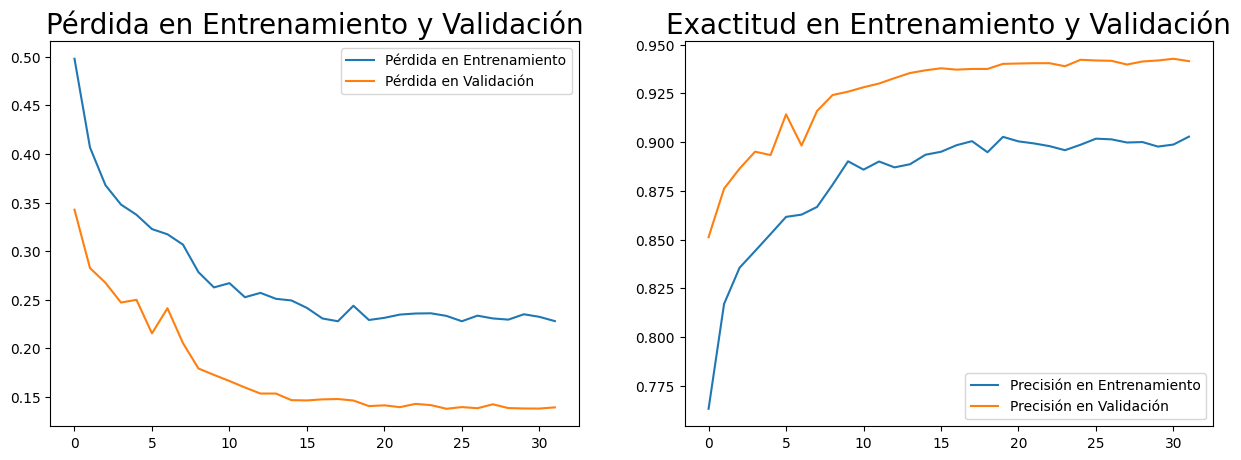

100%|██████████| 90/90 [00:10<00:00,  8.24it/s]


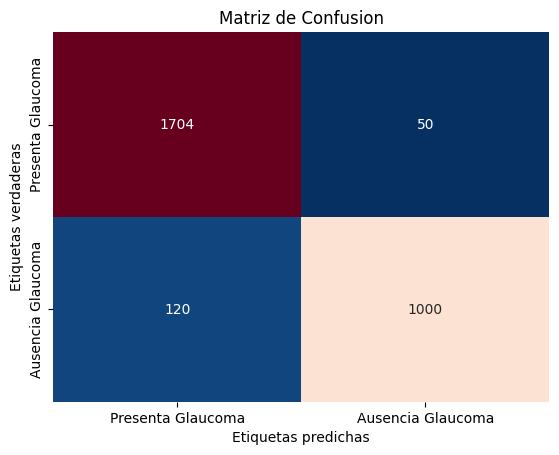

                   precision    recall  f1-score   support

Presenta Glaucoma       0.93      0.97      0.95      1754
Ausencia Glaucoma       0.95      0.89      0.92      1120

         accuracy                           0.94      2874
        macro avg       0.94      0.93      0.94      2874
     weighted avg       0.94      0.94      0.94      2874



In [11]:
trainer.plot_loss_and_accuracy()
y_true, y_pred = trainer.evaluate_model_on_test_set(test_loader)
trainer.plot_confusion_matrix_and_report(y_true, y_pred, label_list=["Presenta Glaucoma", "Ausencia Glaucoma"])

# Resultados Y Predicciones

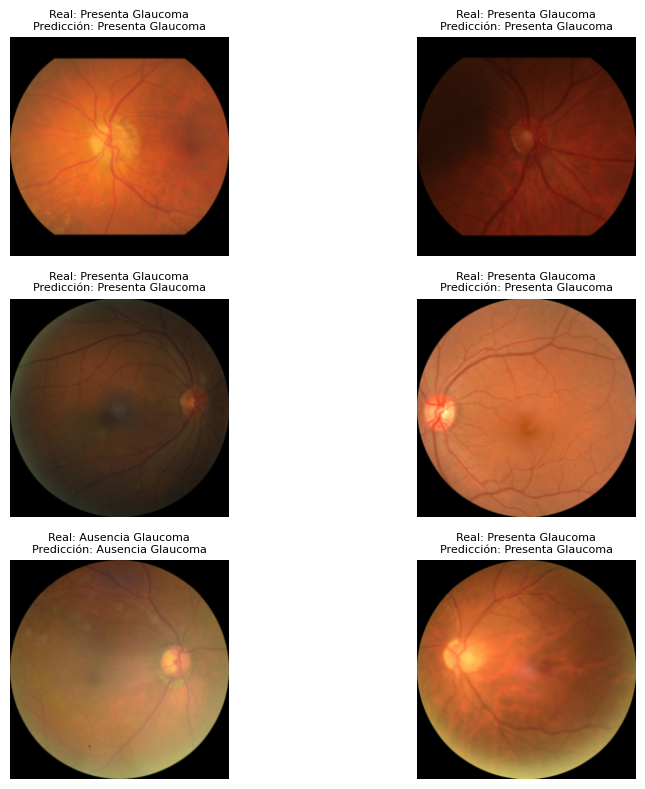

In [13]:
num_images_to_display = 6  # Número de imágenes a visualizar
label_list = ["Presenta Glaucoma", "Ausencia Glaucoma"]  # Lista de etiquetas

# Llamar al método visualize_predictions
trainer.visualize_predictions(num_images_to_display, test_dataset, label_list)

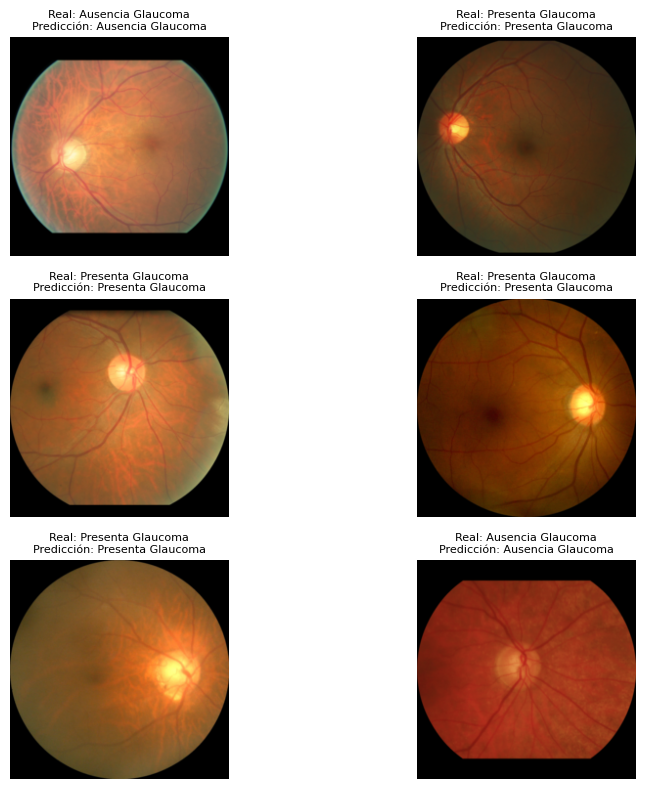

In [30]:
num_images_to_display = 6  # Número de imágenes a visualizar
label_list = ["Presenta Glaucoma", "Ausencia Glaucoma"]  # Lista de etiquetas

# Llamar al método visualize_predictions
trainer.visualize_predictions(num_images_to_display, test_dataset, label_list)

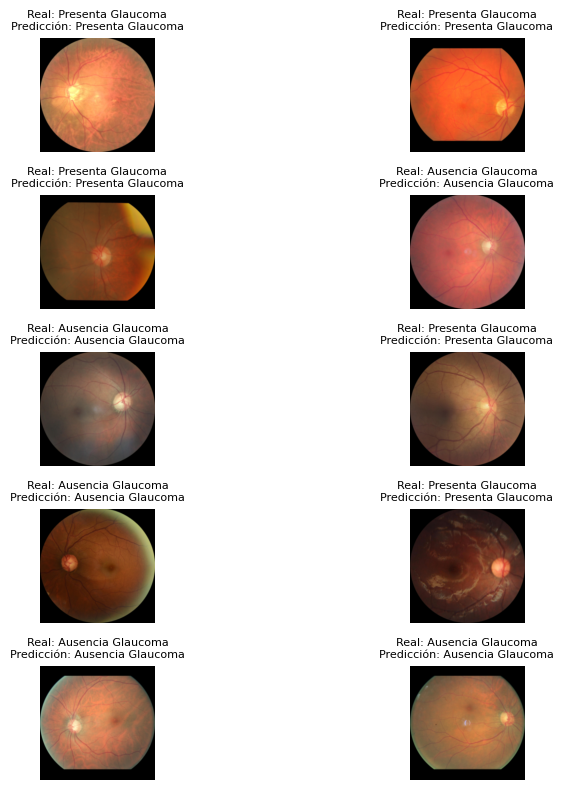

In [35]:
import random

num_images_to_display = 10  # Número total de imágenes a visualizar
num_images_per_label = 5  # Número de imágenes por cada categoría (glaucoma y ausencia)
label_list = ["Presenta Glaucoma", "Ausencia Glaucoma"]  # Lista de etiquetas

# Obtener índices aleatorios para las imágenes de glaucoma
glaucoma_indices = random.sample(range(len(test_dataset)), num_images_per_label)
# Obtener índices aleatorios para las imágenes sin glaucoma
non_glaucoma_indices = random.sample(range(len(test_dataset)), num_images_per_label)

# Crear una lista de índices combinados
combined_indices = glaucoma_indices + non_glaucoma_indices

# Mezclar los índices para mostrar las imágenes en un orden aleatorio
random.shuffle(combined_indices)

# Mostrar las imágenes aleatorias
trainer.visualize_predictions(num_images_to_display, [test_dataset[i] for i in combined_indices], label_list)


Mas ejemplos con el modelo final

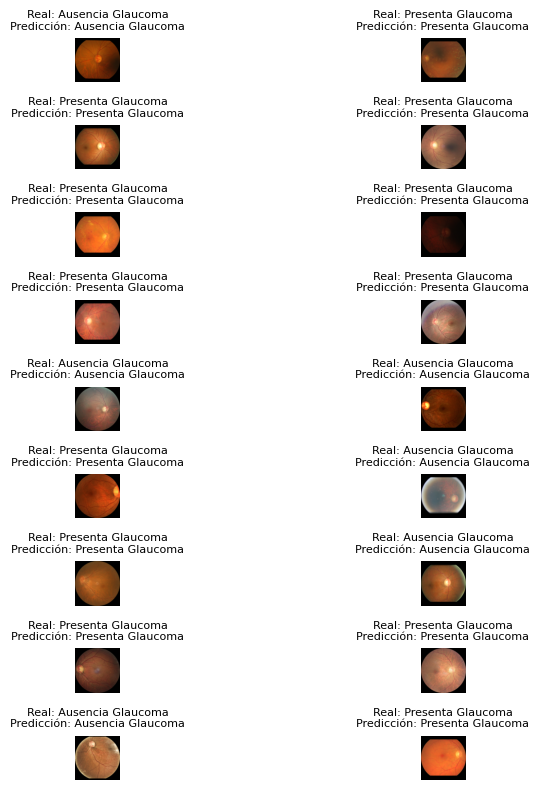

In [39]:
num_images_to_display = 18  # Número total de imágenes a visualizar
num_images_per_label = 9  # Número de imágenes por cada categoría (glaucoma y ausencia)
label_list = ["Presenta Glaucoma", "Ausencia Glaucoma"]  # Lista de etiquetas

# Obtener índices aleatorios para las imágenes de glaucoma
glaucoma_indices = random.sample(range(len(test_dataset)), num_images_per_label)
# Obtener índices aleatorios para las imágenes sin glaucoma
non_glaucoma_indices = random.sample(range(len(test_dataset)), num_images_per_label)

# Crear una lista de índices combinados
combined_indices = glaucoma_indices + non_glaucoma_indices

# Mezclar los índices para mostrar las imágenes en un orden aleatorio
random.shuffle(combined_indices)

# Mostrar las imágenes aleatorias
trainer.visualize_predictions(num_images_to_display, [test_dataset[i] for i in combined_indices], label_list)


# Aplicación Práctica

In [40]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


In [43]:
import streamlit as st
from PIL import Image
import base64
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import time

def get_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def set_background(png_file):
    bin_str = get_base64(png_file)
    page_bg_img = '''
    <style>
    .stApp {
        background-image: url("data:image/png;base64,%s");
        background-size: cover;
    }
    .title-wrapper {
        display: flex;
        align-items: center;
        justify-content: center;
    }
    .title-wrapper h1 {
        font-size: 122px; /* Ajusta el tamaño de la fuente según tus necesidades */
        color: white; /* Cambia el color del texto según tus necesidades */
        text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); /* Añade sombra al texto */
    }
    </style>
    ''' % bin_str
    st.markdown(page_bg_img, unsafe_allow_html=True)

# Llamar a la función con la ruta de la imagen
set_background("/content/images/app/back2.png")


# Mostrar el logo y el nombre de la aplicación en dos columnas
col1, col2 = st.columns([1, 2])
with col1:
    st.image("/content/images/app/logo2.png", width=380)  # Ajusta el valor de width según tus necesidades
with col2:
    st.markdown('<div class="title-wrapper"><h1> Glauc<span style="color: #48B4B8;">ia</span></h1></div>', unsafe_allow_html=True)


# Definir el mapa de etiquetas
label_map = {
    0: "Glaucoma Positiva",
    1: "Glaucoma Negativa",
}

# Preprocesamiento de la imagen
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Añadir dimensión de lote
    return input_batch

# Clasificación de la imagen
def classify_image(model, input_batch):
    with torch.no_grad():
        output = model(input_batch)
        _, predicted = torch.max(output, 1)
        return predicted.item(), output

def main():
    st.title("Detección de Glaucoma")

    # Cargar el modelo EfficientNet-V2
    class_size = 2
    model = models.efficientnet_v2_s(pretrained=True)
    model.classifier[1] = torch.nn.Linear(1280, class_size)
    model.load_state_dict(torch.load("/content/checkpoints/best.pth", map_location=torch.device('cpu')))  # Cargar el modelo pre-entrenado en la CPU
    model.eval()

    # Subida de la imagen
    uploaded_file = st.file_uploader("Sube una imagen...", type=["jpg", "png"])

    # Banner para seleccionar imágenes de muestra
    st.markdown("---")
    st.subheader("Imágenes de muestra:")
    row = st.columns(4)
    sample_images = [
        "/content/images/app/imagen_de_muestra_1.png",
        "/content/images/app/imagen_de_muestra_2.png",
        "/content/images/app/imagen_de_muestra_3.png",
        "/content/images/app/imagen_de_muestra_4.png"
    ]
    for i, sample_image_path in enumerate(sample_images):
        image = Image.open(sample_image_path)
        if row[i].button(f"Imagen de muestra {i + 1}", key=f"imagen_muestra_{i + 1}"):
            uploaded_file = sample_image_path

    if uploaded_file is not None:
        left_column, right_column = st.columns([2, 3])

        # Mostrar la imagen subida y su predicción a la izquierda y derecha respectivamente
        with left_column:
            st.image(uploaded_file, caption="Imagen cargada", use_column_width=True)
        with right_column:
            input_batch = preprocess_image(uploaded_file)
            prediction, output = classify_image(model, input_batch)
            predicted_class = label_map[prediction]
            confidence = torch.nn.functional.softmax(output, dim=1)[0][prediction].item() * 100
            if predicted_class == "Glaucoma Positiva":
                st.write(f"<p style='font-size:20px; text-align:center; color:red;'>Predicción: {predicted_class}</p>", unsafe_allow_html=True)
            else:
                st.write(f"<p style='font-size:20px; text-align:center;'>Predicción: {predicted_class}</p>", unsafe_allow_html=True)
            st.write(f"<p style='font-size:20px; text-align:center;'>Confianza: {confidence:.2f}%</p>", unsafe_allow_html=True)

        # Tiempo de Inferencia
        start_time = time.time()
        prediction, _ = classify_image(model, input_batch)
        inference_time = time.time() - start_time
        st.write(f"<p style='font-size:20px; text-align:center;'>Tiempo de Inferencia: {inference_time:.4f} segundos</p>", unsafe_allow_html=True)

    if uploaded_file is None:
        st.warning("Por favor, sube una imagen o selecciona una de las imágenes de muestra.")

if __name__ == "__main__":
    main()


2024-02-28 17:27:36.428 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
main()

Aplicación de Deteccion del Glaucoma

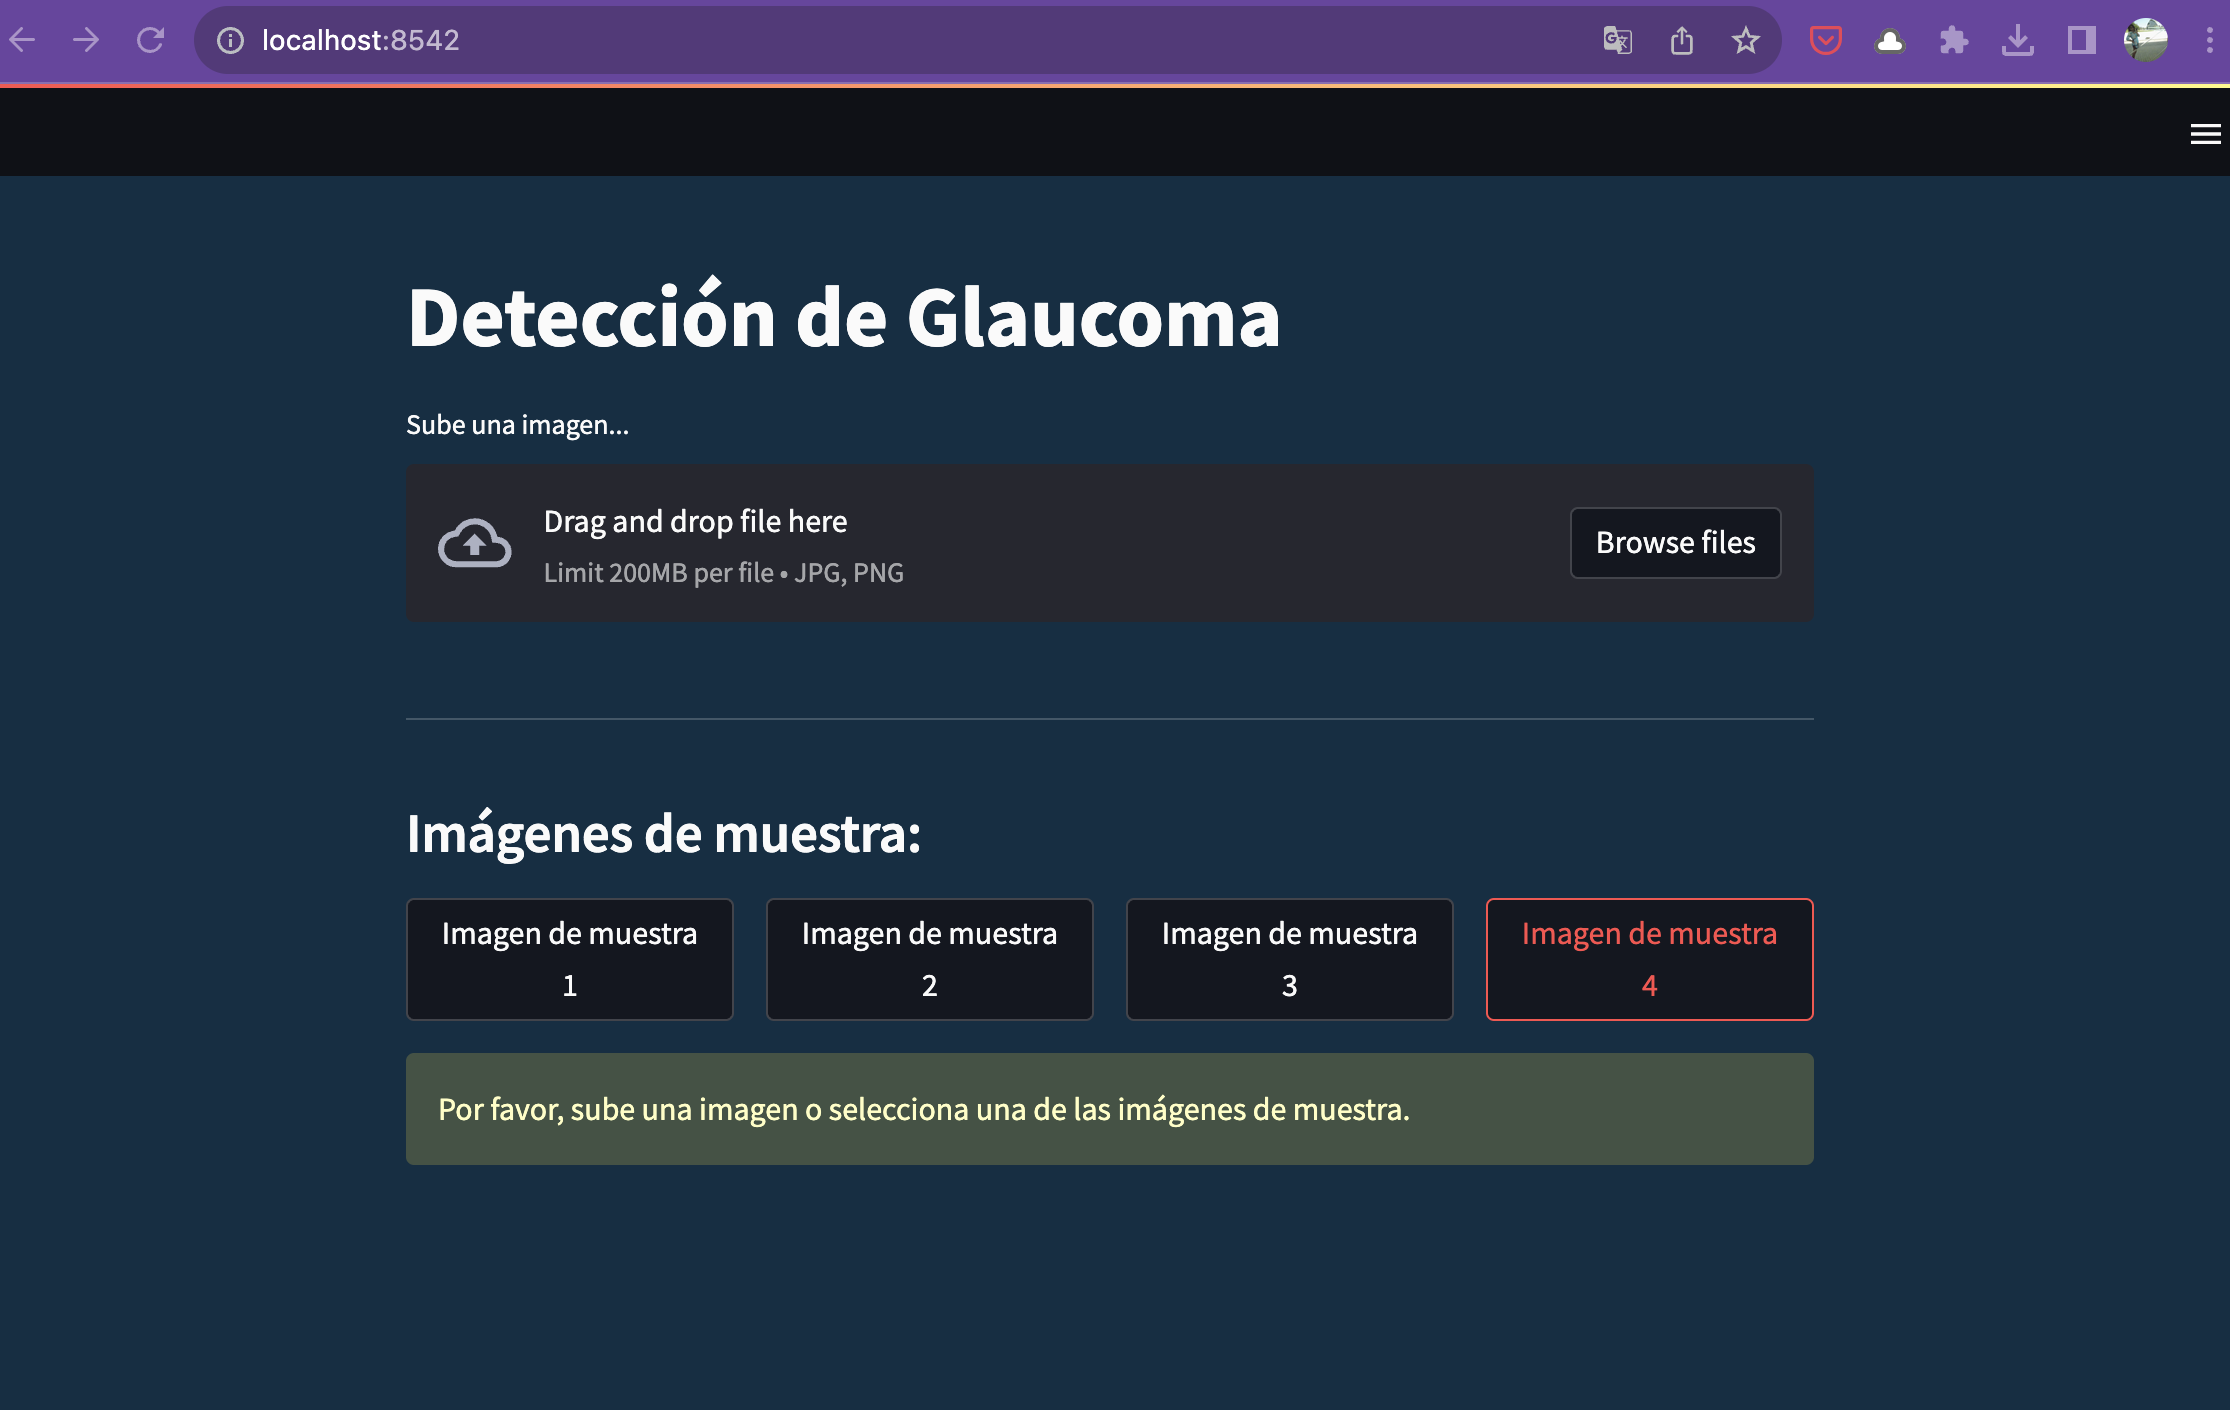